In [1]:
import numpy as np
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import simple_norm

%matplotlib inline
import pylab as pl

In [2]:
import reproject

In [3]:
import regions

In [4]:
brick_center = SkyCoord(0.257, 0.018, unit=(u.deg, u.deg), frame='galactic')

In [5]:
co_image = fits.open('/orange/adamginsburg/cmz/CHIMPS/12CO_CMZ_INTEG_LB.fits')
# co_image_cutout = Cutout2D(co_image[0].data, SkyCoord('17:46:12.752 -28:43:52.4', unit=(u.h, u.deg), frame='fk5'), size=10*u.arcsec, wcs=WCS(co_image[0].header)) ## this is that interesting cluster zone
co_image_cutout = Cutout2D(co_image[0].data, brick_center, size=5*u.arcmin, wcs=WCS(co_image[0].header))
coheader = co_image[0].header
cowcs = WCS(coheader)

Set OBSGEO-B to    19.822842 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.822842 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
from spectral_cube import SpectralCube
cube = SpectralCube.read('/orange/adamginsburg/cmz/CHIMPS/12CO_GC_359-000_mosaic.fits')

In [7]:
ppmap_cdens_full = fits.open('/orange/adamginsburg/cmz/ppmap/PPMAP_Results/l000_results/l000_cdens.fits')
ppmap_tem_full = fits.open('/orange/adamginsburg/cmz/ppmap/PPMAP_Results/l000_results/l000_temp.fits')

ppmap_col = Cutout2D(ppmap_cdens_full[0].data,
                     brick_center,
                     size=5*u.arcmin, wcs=WCS(ppmap_cdens_full[0].header))
ppmap_tem = Cutout2D(ppmap_tem_full[0].data,
                     brick_center,
                     size=5*u.arcmin, wcs=WCS(ppmap_tem_full[0].header))

In [8]:
brickreg = regions.Regions.read('/blue/adamginsburg/adamginsburg/jwst/brick/regions/brick_polygon.reg')

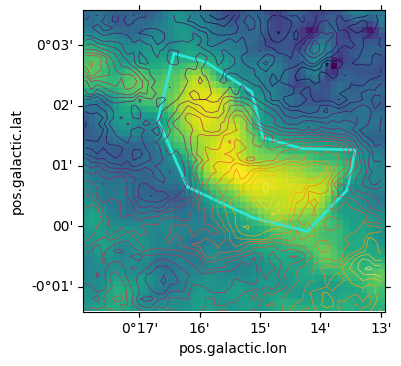

In [9]:
fig = pl.figure(dpi=100)
ax = fig.add_subplot(projection=ppmap_col.wcs)
pl.imshow(ppmap_col.data, norm=simple_norm(ppmap_col.data, stretch='log'))
ax.contour(co_image_cutout.data, transform=ax.get_transform(co_image_cutout.wcs), cmap='inferno', levels=20, linewidths=[0.5]*20)
brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

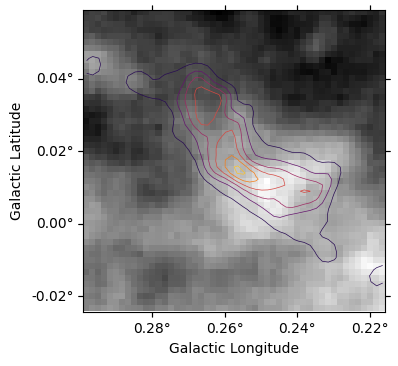

In [10]:
fig = pl.figure(dpi=100)
ax = fig.add_subplot(projection=co_image_cutout.wcs)
pl.imshow(co_image_cutout.data, norm=simple_norm(co_image_cutout.data, stretch='linear', ),
          cmap='gray')
ax.contour(ppmap_col.data, transform=ax.get_transform(ppmap_col.wcs),
           cmap='inferno', levels=6, linewidths=[0.5]*20)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
ax.xaxis.set_units(u.deg)
ax.yaxis.set_units(u.deg)
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

pl.savefig("PPMAP_on_CO32.pdf", dpi=150)
#brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

In [11]:
ppmapcdens_to_co,_ = reproject.reproject_interp(ppmap_cdens_full, coheader)

In [12]:
ppmaptem_to_co,_ = reproject.reproject_interp(ppmap_tem_full, coheader)

In [13]:
brickpreg = brickreg[0].to_pixel(WCS(co_image[0].header))

In [14]:
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 14

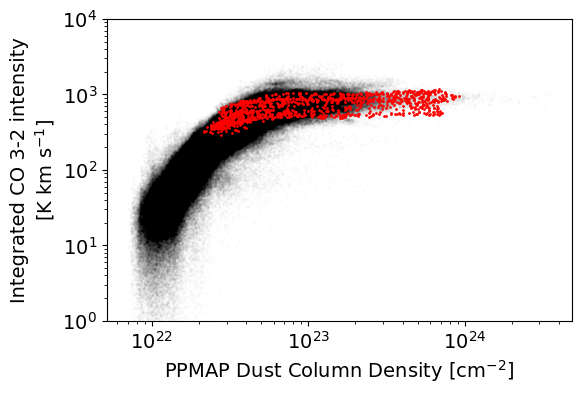

In [15]:
# whole CMZ
pl.scatter(ppmapcdens_to_co.ravel()*1e20, co_image[0].data.ravel(), s=1, c='k', alpha=0.01)

co = brickpreg.to_mask().cutout(co_image[0].data)
du = brickpreg.to_mask().cutout(ppmapcdens_to_co)

pl.scatter(du.ravel()*1e20, co.ravel(), s=1, c='r')
pl.loglog();
pl.ylim(1,1e4)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated CO 3-2 intensity\n[K km s$^{-1}$]");

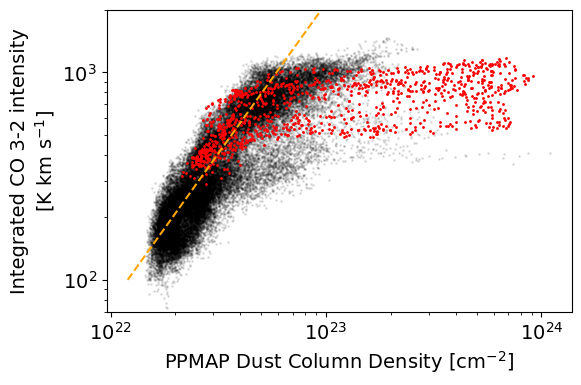

In [16]:
# dust ridge
dustridge_dust = Cutout2D(ppmapcdens_to_co,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

dustridge_co = Cutout2D(co_image[0].data,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

pl.scatter(dustridge_dust.data.ravel()*1e20, dustridge_co.data.ravel(), s=1, c='k', alpha=0.1)

co = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_co.data)
du = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_dust.data)

pl.scatter(du.ravel()*1e20, co.ravel(), s=1, c='r')
pl.plot([1.2e22,0.95e23], [1e2, 2e3], linestyle='--', color='orange')
pl.loglog();
pl.ylim(70,2e3)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated CO 3-2 intensity\n[K km s$^{-1}$]");
pl.savefig("BrickOnDustRidge_CO32_vs_ppmapdust.pdf", dpi=150)

In [17]:
# guver 2009
av_to_nh2 = 2.2e21*u.cm**-2
# from ColorVsCOIce "fit": av_to_co = 0.12 * av + 15.8 
#column_to_coice = 10**(0.12